#### **Fundamentos de Bancos de Dados Relacionais e NoSQL**

#### **Conteúdo - Bases e Notebook da aula**

https://github.com/FIAP/Pos_Tech_DTAT/tree/main/Fase%203

#### **Importação de pacotes, bibliotecas e funções (def)**

In [6]:
# Importar biblioteca completa
import boto3
import pandas as pd
import os
import plotly.express as px
import requests
import duckdb
import mongomock
import fakeredis
import uuid
import networkx as nx
import matplotlib.pyplot as plt

# Importar função especifica de um módulo
from botocore.exceptions import BotoCoreError, ClientError
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
from io import StringIO
from pprint import pprint
from astrapy import DataAPIClient
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
from pprint import pprint

In [2]:
# Testar a conexão ao banco de dados
def test_connection(engine):

    try:
        with engine.connect() as connection:
            
            # Testar a versão do PostgreSQL
            result = connection.execute(text("SELECT version();"))
            versao = result.fetchone()
            print("✅ Conectado com sucesso:", versao[0])

            # Listar as tabelas no schema público
            result = connection.execute(text("""
                SELECT table_name
                FROM information_schema.tables
                WHERE table_schema = 'public';
            """))
            tabelas = result.fetchall()
            print("📄 Tabelas no banco:")
            for tabela in tabelas:
                print("  -", tabela[0])

    except Exception as e:
        print("❌ Erro ao executar comandos:", e)


#### **Instalação do AWS CLI (Opcional, mas Recomendado)**

Para rodar comandos da AWS no terminal para testar credenciais, criar buckets ou consultar recursos instale o **AWS CLI v2**.

##### **macOS / Linux (zsh ou bash)**

**Instalação com Homebrew (recomendado para macOS)**
```bash
brew install awscli
```

##### **Instalação manual**
```bash
curl "https://awscli.amazonaws.com/AWSCLIV2.pkg" -o "AWSCLIV2.pkg"
sudo installer -pkg AWSCLIV2.pkg -target /
```

##### **Verificar instalação**
```bash
aws --version
```

##### **Windows**

1. Baixe o instalador: [AWS CLI v2](https://awscli.amazonaws.com/AWSCLIV2.msi)
2. Execute o instalador e finalize.
3. Teste no PowerShell:
```bash
aws --version
```

##### **Testar credenciais**
Após instalar o **AWS CLI**, teste o perfil `academy` criado:

```bash
aws sts get-caller-identity --profile academy
```

Se retornar o **Account ID** e o **ARN**, as credenciais estão funcionando ✅

#### **Credenciais do AWS Academy** 

Para seguir com as etapas desse notebook será necessario pegar as credencias do AWS Academy e criar o arquivo com essas credencias:

**1. Pegar credenciais do AWS Academy**  
1. Acesse [AWS Academy](https://awsacademy.instructure.com/)
2. Acesse a opção **Cursos** no lado esquerdo e acesse o seu respectivo curso
3. Acessa a opçãp **Módulos**
4. Acesse a opção **Iniciar os laboratórios de aprendizagem da AWS Academy**
5. Clique em **Start Lab**
6. Clique em **AWS Details**
7. Clique em **AWS CLI: Show** e copie:
   - **AWS Access Key ID**
   - **AWS Secret Access Key**
   - **Session Token**

⚠️ As credenciais são temporárias (válidas por 3 horas).

**2. Criar arquivo de credenciais**  

Crie o arquivo **`credentials`** no caminho:

- **macOS/Linux:** `~/.aws/credentials`
- **Windows:** `%USERPROFILE%\.aws\credentials`

⚠️ Salvar o arquivo sem formato --> Na opçãp Tipo deixar Todos os arquivos

**3. Conteúdo do arquivo**
```ini
[academy]
aws_access_key_id = SUA_ACCESS_KEY
aws_secret_access_key = SUA_SECRET_KEY
aws_session_token = SEU_SESSION_TOKEN
region = sa-east-1
output = json
```

**4. Testar configuração**
```bash
aws sts get-caller-identity --profile academy
```

Se tudo estiver certo, rode o notebook.  
Agora ele **usa automaticamente o perfil `academy`** para se conectar à AWS.

#### **Testar conexão AWS via Python**

In [3]:
# Validar conexão
try:
    session = boto3.Session(profile_name="academy")
    sts = session.client("sts")
    identity = sts.get_caller_identity()
    print("✅ Conectado à conta\n")
    print("UserId:", identity["UserId"])
    print("Account:", identity["Account"])
    print("Arn:", identity["Arn"])

except (BotoCoreError, ClientError) as e:
    print("❌ Erro ao conectar à AWS. Verifique suas credenciais e tente novamente.")
    print("Detalhes do erro:", e)


✅ Conectado à conta

UserId: AROAWIUHO6CVULDIIR3FL:user4308167=ricardviana1@gmail.com
Account: 430854566059
Arn: arn:aws:sts::430854566059:assumed-role/voclabs/user4308167=ricardviana1@gmail.com


#### **Configuração do PostgreSQL na AWS RDS**

##### 1. **Criar instância RDS com PostgreSQL (SandBox)**

1. Acesse o console AWS → [https://us-east-1.console.aws.amazon.com/rds/home?region=us-east-1#](https://console.aws.amazon.com/rds/)
2. Clique em **Criar banco de dados**
3. Selecione:
   - **Tipo de banco:** PostgreSQL
   - **Versão:** PostgreSQL 15 (ou mais recente)
   - **Modelo de uso:** SandBox
   - **Identificador da instância:** `postgres-db`
   - **Usuário:** `postgres`
   - **Senha:** crie uma senha segura
4. Tipo de instância: `db.t3.micro`
5. Armazenamento: 20 GB (SSD General Purpose)
6. **Acesso público:** Habilitado (Sim)
7. **Nome do banco de dados inicial:** `db_relacional`
8. Clique em **Criar banco de dados**

##### **2. Liberar o IP na VPC / Grupo de Segurança (Security Group)**

1. Vá para **EC2 > Grupos de Segurança**
2. Encontre o grupo associado à instância RDS
3. Clique em **Editar regras de entrada**
4. Adicione uma nova regra:
   - Tipo: `PostgreSQL`
   - Porta: `5432`
   - Origem: `Seu IP` (ou `0.0.0.0/0` temporariamente para teste – cuidado com isso em produção)
5. Salve as alterações.

✅ Agora o acesso externo ao banco estará liberado para seu IP

##### **3. Copie o Endpoint da RDS**

1. Volte ao RDS > Banco de dados > `bd-relacional`
2. Copie o valor do campo **Endpoint** (algo como `bd-relacional.xxxxxx.us-east-1.rds.amazonaws.com`)
3. Use esse endpoint no notebook para se conectar com o PostgreSQL

#### **Aula 1 - Introdução ao Banco De Dados Relacionais**

##### **Conectar ao PostgreSQL via RDS + Executar Comandos SQL**

In [4]:
# Criar a engine para conexão ao banco de dados usando .env

load_dotenv()

usuario = os.getenv("POSTGRES_USER")
senha = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")
porta = os.getenv("POSTGRES_PORT")
banco = os.getenv("POSTGRES_DB")

engine = create_engine(f"postgresql+psycopg2://{usuario}:{senha}@{host}:{porta}/{banco}")

In [5]:
# Testar a conexão
test_connection(engine)

✅ Conectado com sucesso: PostgreSQL 17.4 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 12.4.0, 64-bit
📄 Tabelas no banco:
  - dim_cliente
  - dim_produto
  - fato_pedidos
  - pedidos
  - produtos
  - itens_pedido
  - clientes
  - tipos_produto


In [6]:
# Dropar as tabelas --> CASCADE garante que todas as dependências (FKs) sejam eliminadas junto com a tabela
drop_script = """
DROP TABLE IF EXISTS itens_pedido CASCADE;
DROP TABLE IF EXISTS pedidos CASCADE;
DROP TABLE IF EXISTS produtos CASCADE;
DROP TABLE IF EXISTS clientes CASCADE;
DROP TABLE IF EXISTS tipos_produto CASCADE;
"""

conn = engine.raw_connection()
try:
    cursor = conn.cursor()
    cursor.execute(drop_script)
    conn.commit()
    print("🗑️ Todas as tabelas foram deletadas com sucesso.")
finally:
    cursor.close()
    conn.close()

# Listar de comandos individuais
ddl_commands = [
    """
    CREATE TABLE IF NOT EXISTS tipos_produto (
      id_tipo SERIAL PRIMARY KEY,
      nome_tipo VARCHAR(50) NOT NULL
    );
    """,
    """
    CREATE TABLE IF NOT EXISTS produtos (
      id_produto SERIAL PRIMARY KEY,
      nome_produto VARCHAR(100) NOT NULL,
      preco DECIMAL(10,2) NOT NULL,
      id_tipo INT REFERENCES tipos_produto(id_tipo)
    );
    """,
    """
    CREATE TABLE IF NOT EXISTS clientes (
      id_cliente SERIAL PRIMARY KEY,
      nome VARCHAR(100) NOT NULL,
      email VARCHAR(100),
      telefone VARCHAR(20), 
      cidade VARCHAR(100) NOT NULL, 
      estado VARCHAR(2) NOT NULL
    );
    """,
    """
    CREATE TABLE IF NOT EXISTS pedidos (
      id_pedido SERIAL PRIMARY KEY,
      data_pedido DATE NOT NULL,
      status VARCHAR(20) NOT NULL,
      id_cliente INT NOT NULL REFERENCES clientes(id_cliente)
    );
    """,
    """
    CREATE TABLE IF NOT EXISTS itens_pedido (
    id_item SERIAL PRIMARY KEY,
    id_pedido INT NOT NULL,
    id_produto INT NOT NULL,
    quantidade INT NOT NULL,
    preco_unitario DECIMAL(10,2) NOT NULL,
    CONSTRAINT fk_pedido FOREIGN KEY (id_pedido) REFERENCES pedidos(id_pedido) ON DELETE CASCADE,
    CONSTRAINT fk_produto FOREIGN KEY (id_produto) REFERENCES produtos(id_produto) ON DELETE CASCADE
    );

    """
]

# Lista de nomes das tabelas na mesma ordem dos comandos
table_names = [
    "tipos_produto",
    "produtos",
    "clientes",
    "pedidos",
    "itens_pedido"
]

with engine.begin() as conn:
    for cmd, table in zip(ddl_commands, table_names):
        conn.execute(text(cmd))
        print(f"✅ Tabela '{table}' criada com sucesso!")

🗑️ Todas as tabelas foram deletadas com sucesso.
✅ Tabela 'tipos_produto' criada com sucesso!
✅ Tabela 'produtos' criada com sucesso!
✅ Tabela 'clientes' criada com sucesso!
✅ Tabela 'pedidos' criada com sucesso!
✅ Tabela 'itens_pedido' criada com sucesso!


In [7]:
# Verificar as chaves primarias
df_pks = pd.read_sql_query("""
SELECT 
    kcu.table_schema,
    kcu.table_name,
    kcu.column_name,
    tc.constraint_name
FROM information_schema.table_constraints tc
JOIN information_schema.key_column_usage kcu
  ON tc.constraint_name = kcu.constraint_name
WHERE tc.constraint_type = 'PRIMARY KEY'
  AND kcu.table_schema = 'public';
""", con=engine)

df_pks.head(10)

,table_schema,table_name,column_name,constraint_name
0,public,dim_cliente,id_cliente,dim_cliente_pkey
1,public,dim_produto,id_produto,dim_produto_pkey
2,public,fato_pedidos,id_pedido,fato_pedidos_pkey
3,public,tipos_produto,id_tipo,tipos_produto_pkey
4,public,produtos,id_produto,produtos_pkey
5,public,clientes,id_cliente,clientes_pkey
6,public,pedidos,id_pedido,pedidos_pkey
7,public,itens_pedido,id_item,itens_pedido_pkey


In [8]:
# Verificar chaves estrangeiras e relacionamento
df_fks = pd.read_sql_query("""
SELECT 
    tc.table_name AS tabela_origem,
    kcu.column_name AS coluna_origem,
    ccu.table_name AS tabela_referenciada,
    ccu.column_name AS coluna_referenciada
FROM information_schema.table_constraints AS tc
JOIN information_schema.key_column_usage AS kcu
  ON tc.constraint_name = kcu.constraint_name
JOIN information_schema.constraint_column_usage AS ccu
  ON ccu.constraint_name = tc.constraint_name
WHERE tc.constraint_type = 'FOREIGN KEY'
  AND tc.table_schema = 'public';
""", con=engine)

df_fks.head()


,tabela_origem,coluna_origem,tabela_referenciada,coluna_referenciada
0,fato_pedidos,id_cliente,dim_cliente,id_cliente
1,fato_pedidos,id_produto,dim_produto,id_produto
2,produtos,id_tipo,tipos_produto,id_tipo
3,pedidos,id_cliente,clientes,id_cliente
4,itens_pedido,id_pedido,pedidos,id_pedido


In [9]:
# Realizar join entre as tabelas
df_relacionamentos = pd.read_sql_query("""
SELECT 
  tc.constraint_name,
  tc.table_name AS origem,
  kcu.column_name AS coluna_origem,
  ccu.table_name AS destino,
  ccu.column_name AS coluna_destino
FROM information_schema.table_constraints AS tc
JOIN information_schema.key_column_usage AS kcu
  ON tc.constraint_name = kcu.constraint_name
JOIN information_schema.constraint_column_usage AS ccu
  ON ccu.constraint_name = tc.constraint_name
WHERE tc.constraint_type = 'FOREIGN KEY'
ORDER BY origem;
""", con=engine)

df_relacionamentos.head()


,constraint_name,origem,coluna_origem,destino,coluna_destino
0,fato_pedidos_id_cliente_fkey,fato_pedidos,id_cliente,dim_cliente,id_cliente
1,fato_pedidos_id_produto_fkey,fato_pedidos,id_produto,dim_produto,id_produto
2,fk_pedido,itens_pedido,id_pedido,pedidos,id_pedido
3,fk_produto,itens_pedido,id_produto,produtos,id_produto
4,pedidos_id_cliente_fkey,pedidos,id_cliente,clientes,id_cliente


In [10]:
# Executar arquivos .sql
truncate_script = """
TRUNCATE TABLE itens_pedido CASCADE;
TRUNCATE TABLE pedidos CASCADE;
TRUNCATE TABLE produtos CASCADE;
TRUNCATE TABLE clientes CASCADE;
TRUNCATE TABLE tipos_produto CASCADE;
"""

github_urls = [
    "https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/refs/heads/main/Fase%203/Aula4/sql/aula4/tipos_produto.sql",
    "https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/refs/heads/main/Fase%203/Aula4/sql/aula4/produtos.sql",
    "https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/refs/heads/main/Fase%203/Aula4/sql/aula4/clientes.sql",
    "https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/refs/heads/main/Fase%203/Aula4/sql/aula4/pedidos.sql",
    "https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/refs/heads/main/Fase%203/Aula4/sql/aula4/itens_pedido.sql"
]

with engine.begin() as conn:
    conn.execute(text(truncate_script))
    print("🗑️ Dados apagados de todas as tabelas.")

    for url in github_urls:
        response = requests.get(url)
        response.raise_for_status()
        sql_content = response.text
        conn.execute(text(sql_content))
        print(f"✅ Executado: {url.split('/')[-1]}")

🗑️ Dados apagados de todas as tabelas.
✅ Executado: tipos_produto.sql
✅ Executado: produtos.sql
✅ Executado: clientes.sql
✅ Executado: pedidos.sql
✅ Executado: itens_pedido.sql


In [11]:
# Join para analise de vendas
df = pd.read_sql_query(

"""
                       
SELECT 
  c.nome AS cliente,
  p.data_pedido as data_pedido,
  pr.nome_produto AS produto,
  pr.preco as preco,
  t.nome_tipo AS tipo_produto,
  ip.quantidade as quantidade,
  (pr.preco * ip.quantidade) AS total_venda

FROM itens_pedido ip

JOIN pedidos p ON ip.id_pedido = p.id_pedido
JOIN clientes c ON p.id_cliente = c.id_cliente
JOIN produtos pr ON ip.id_produto = pr.id_produto
JOIN tipos_produto t ON pr.id_tipo = t.id_tipo;

"""
,con=engine)

df.head()


,cliente,data_pedido,produto,preco,tipo_produto,quantidade,total_venda
0,Enzo Gabriel Monteiro,2025-03-18,Excepturi Reprehenderit,367.57,Ferramentas,4,1470.28
1,Dr. Juan Melo,2024-08-18,Animi Tempore,130.85,Ferramentas,1,130.85
2,João Felipe da Luz,2024-11-08,Expedita Iste,497.62,Higiene,2,995.24
3,João Lucas Fernandes,2025-05-29,Vero Eius,292.34,Livros,5,1461.70
4,Enzo Gabriel Freitas,2025-01-29,Quos Nam,409.85,Ferramentas,2,819.70


In [12]:
# Gerar grafico
fig = px.bar(df, x="cliente", y="total_venda", color="produto", 
             title="Total de Vendas por Cliente e Produto")
fig.show()


In [13]:
deletar_tabelas = 'n'  # Altere para s se quiser dropar

if deletar_tabelas.lower() == 's':
    drop_script = """
    DROP TABLE IF EXISTS itens_pedido CASCADE;
    DROP TABLE IF EXISTS pedidos CASCADE;
    DROP TABLE IF EXISTS produtos CASCADE;
    DROP TABLE IF EXISTS clientes CASCADE;
    DROP TABLE IF EXISTS tipos_produto CASCADE;
    """
    conn = engine.raw_connection()

    try:
        cursor = conn.cursor()
        cursor.execute(drop_script)
        conn.commit()
        print("🗑️ Todas as tabelas foram deletadas com sucesso")
    finally:
        cursor.close()
        conn.close()
else:
    print(f"⚠️ Drop de tabelas não executado. Variável de controle está {deletar_tabelas}")

⚠️ Drop de tabelas não executado. Variável de controle está n


#### **Aula 3 - Stacks Modernas, Data Warehouse, Data Lake e Lakehouse, Data Mesh e Data Fabric**

##### **Modelo Dimensional em DBML – Diagrama DW (dimensões e fato)**

Criar o Diagrama Entidade-Relacionamento (DER) usando o site https://dbdiagram.io/home e o seguinte código DBML (Database Markup Language ou Linguagem de Marcação para Banco de Dados):   

```dbml
Table dim_cliente {
  id_cliente int [pk]
  nome varchar
  idade int
  cidade varchar
}

Table dim_produto {
  id_produto int [pk]
  nome_produto varchar
  categoria varchar
  preco decimal
}

Table fato_pedidos {
  id_pedido int [pk]
  id_cliente int [ref: > dim_cliente.id_cliente]
  id_produto int [ref: > dim_produto.id_produto]
  id_data int [ref: > dim_data.id_data]
  id_regiao int [ref: > dim_regiao.id_regiao]
  data_pedido date
  quantidade int
  valor_total decimal
}

Table dim_data {
  id_data int [pk]
  data date
  ano int
  mes int
  dia int
  dia_semana varchar
  nome_mes varchar
}

Table dim_regiao {
  id_regiao int [pk]
  nome_regiao varchar
  estado varchar
  cidade varchar
}


![Diagrama DW](imagame.png)


##### **Códigos - Carregar dados no PostgreSQL**

In [14]:
# Criar tabelas
ddl_dim_fato = [
    """
    CREATE TABLE IF NOT EXISTS dim_cliente (
      id_cliente INT PRIMARY KEY,
      nome VARCHAR(100),
      idade INT,
      cidade VARCHAR(100)
    );
    """,
    """
    CREATE TABLE IF NOT EXISTS dim_produto (
      id_produto INT PRIMARY KEY,
      nome_produto VARCHAR(100),
      categoria VARCHAR(50),
      preco DECIMAL(10,2)
    );
    """,
    """
    CREATE TABLE IF NOT EXISTS fato_pedidos (
      id_pedido INT PRIMARY KEY,
      id_cliente INT REFERENCES dim_cliente(id_cliente),
      id_produto INT REFERENCES dim_produto(id_produto),
      data_pedido DATE,
      quantidade INT,
      valor_total DECIMAL(10,2)
    );
    """
]

table_names = [
    "dim_cliente",
    "dim_produto",
    "fato_pedidos"
]

# Validar se as tabelas já existe
with engine.begin() as conn:
    for cmd, table in zip(ddl_dim_fato, table_names):
        result = conn.execute(
            text(f"SELECT EXISTS (SELECT 1 FROM information_schema.tables WHERE table_schema = 'public' AND table_name = '{table}');")
        )
        exists = result.scalar()
        if not exists:
            conn.execute(text(cmd))
            print(f"✅ Tabela '{table}' criada com sucesso!")
        else:
            print(f"⚠️ Tabela '{table}' já existe. Nenhuma alteração feita.")

⚠️ Tabela 'dim_cliente' já existe. Nenhuma alteração feita.
⚠️ Tabela 'dim_produto' já existe. Nenhuma alteração feita.
⚠️ Tabela 'fato_pedidos' já existe. Nenhuma alteração feita.


In [15]:
# Apagar dados das tabelas e executar arquivos .sql
github_urls = [
    "https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/refs/heads/main/Fase%203/Aula4/sql/aula3-dw/insert_dim_cliente.sql",
    "https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/refs/heads/main/Fase%203/Aula4/sql/aula3-dw/insert_dim_produto.sql"

]

delete_script = """
TRUNCATE TABLE dim_cliente, dim_produto CASCADE
"""

with engine.begin() as conn:
    conn.execute(text(delete_script))
    print("🗑️ Dados apagados de todas as tabelas.")

    for url in github_urls:
        response = requests.get(url)
        response.raise_for_status()
        sql_content = response.text
        conn.execute(text(sql_content))
        print(f"✅ Executado: {url.split('/')[-1]}")


🗑️ Dados apagados de todas as tabelas.
✅ Executado: insert_dim_cliente.sql
✅ Executado: insert_dim_produto.sql


In [16]:
# Apagar dados das tabelas e executar arquivos .sql
github_urls = [
    "https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/refs/heads/main/Fase%203/Aula4/sql/aula3-dw/insert_fato_pedidos.sql"
]

delete_script = """
TRUNCATE TABLE fato_pedidos CASCADE
"""

with engine.begin() as conn:
    conn.execute(text(delete_script))
    print("🗑️ Dados apagados de todas as tabelas.")

    for url in github_urls:
        response = requests.get(url)
        response.raise_for_status()
        sql_content = response.text
        conn.execute(text(sql_content))
        print(f"✅ Executado: {url.split('/')[-1]}")


🗑️ Dados apagados de todas as tabelas.
✅ Executado: insert_fato_pedidos.sql


In [17]:
# Join para ver a ultima compra do cliente
df = pd.read_sql_query(

"""
                       
select 
	b.nome, max(a.data_pedido) ultima_compra

from 
	fato_pedidos as a

join dim_cliente as b 
on a.id_cliente = b.id_cliente

group by
	b.nome
	
"""
,con=engine)

df.head()


,nome,ultima_compra
0,Srta. Luna Costa,2024-10-08
1,Vitor Nascimento,2024-12-20
2,Francisco Rezende,2025-04-24
3,Lucas Nascimento,2025-02-05
4,Luiza Duarte,2025-01-02


##### **Códigos - Exportar Postgre para SQL**

In [18]:
# Configurar conexão PostgreSQL
pg_config = {
    "host": host,
    "database": banco,
    "user": usuario,
    "password": senha,
    "port": porta
}

# Configurar dados buckt do AWS S3
bucket_name = "aula-data-lake-430854566059"
s3_prefix = "raw/"

# Listar tabelas a exportar 
tabelas = ['clientes', 'produtos', 'pedidos', 'itens_pedido', 'tipos_produto']

# Validar conexão com PostgreSQL usando o engine
try:
    with engine.connect() as conn:
        result = conn.execute(text("SELECT version();"))
        versao = result.fetchone()
        print(f"✅ Conexão com o PostgreSQL estabelecida: {versao[0]}\n")
except Exception as e:
    print("❌ Erro ao conectar ao PostgreSQL:", e)
    print()

# Criar conexão com S3
s3 = session.client('s3')
region = s3.meta.region_name or "us-east-1" 

# Verificar buckt
try:
    s3.head_bucket(Bucket=bucket_name)
    print(f"✅ Bucket '{bucket_name}' já existe\n")

except ClientError as e:
    error_code = int(e.response['Error']['Code'])
    if error_code == 404:
        print(f"Bucket '{bucket_name}' não existe, criando...\n")
        if region == "us-east-1":
            s3.create_bucket(Bucket=bucket_name)
        else:
            s3.create_bucket(
                Bucket=bucket_name,
                CreateBucketConfiguration={'LocationConstraint': region}
            )
        print(f"Bucket '{bucket_name}' criado com sucesso\n")
    else:
        raise

# Exportar dados do Postgres
for tabela in tabelas:
    print(f"Exportando tabela: {tabela}")
    df = pd.read_sql(f"SELECT * FROM {tabela};", engine) 

    # Salvar como CSV em memória
    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False)

    # Enviar para S3
    s3_key = f"{s3_prefix}{tabela}.csv"
    s3.put_object(Bucket=bucket_name, Key=s3_key, Body=csv_buffer.getvalue())
    print(f"✅ {tabela} salva no S3 em: s3://{bucket_name}/{s3_key}\n")

print("Exportação concluída com sucesso.")


✅ Conexão com o PostgreSQL estabelecida: PostgreSQL 17.4 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 12.4.0, 64-bit

✅ Bucket 'aula-data-lake-430854566059' já existe

Exportando tabela: clientes
✅ clientes salva no S3 em: s3://aula-data-lake-430854566059/raw/clientes.csv

Exportando tabela: produtos
✅ produtos salva no S3 em: s3://aula-data-lake-430854566059/raw/produtos.csv

Exportando tabela: pedidos
✅ pedidos salva no S3 em: s3://aula-data-lake-430854566059/raw/pedidos.csv

Exportando tabela: itens_pedido
✅ itens_pedido salva no S3 em: s3://aula-data-lake-430854566059/raw/itens_pedido.csv

Exportando tabela: tipos_produto
✅ tipos_produto salva no S3 em: s3://aula-data-lake-430854566059/raw/tipos_produto.csv

Exportação concluída com sucesso.


In [19]:
# Criar um dicionário com as opções de armazenamento, especificando o perfil
storage_options = {"profile": "academy"}

# Caminhos no S3
RAW_PREFIX = 's3://aula-data-lake-430854566059/raw/'
SILVER_PREFIX = 's3://aula-data-lake-430854566059/silver/'
GOLD_PREFIX = 's3://aula-data-lake-430854566059/gold/'

# Camada Silver --> Leitura e Limpeza dos Dados
# Uso do storage_options=storage_options para garantir o uso correto das credenciais
clientes = pd.read_csv(RAW_PREFIX + 'clientes.csv', storage_options=storage_options) 
produtos = pd.read_csv(RAW_PREFIX + 'produtos.csv', storage_options=storage_options)
tipos_produto = pd.read_csv(RAW_PREFIX + 'tipos_produto.csv', storage_options=storage_options)
pedidos = pd.read_csv(RAW_PREFIX + 'pedidos.csv', storage_options=storage_options)
itens_pedido = pd.read_csv(RAW_PREFIX + 'itens_pedido.csv', storage_options=storage_options)

# Padronizar colunas para lower case
for df in [clientes, produtos, tipos_produto, pedidos, itens_pedido]:
    df.columns = [col.lower() for col in df.columns]

# Limpeza básica
clientes = clientes.drop_duplicates().dropna(subset=['id_cliente'])
produtos = produtos.drop_duplicates().dropna(subset=['id_produto'])
tipos_produto = tipos_produto.drop_duplicates().dropna(subset=['id_tipo'])
pedidos = pedidos.drop_duplicates().dropna(subset=['id_pedido', 'id_cliente'])
itens_pedido = itens_pedido.drop_duplicates().dropna(subset=['id_item', 'id_pedido', 'id_produto'])

# Padronização de datas
if 'data_pedido' in pedidos.columns:
    pedidos['data_pedido'] = pd.to_datetime(pedidos['data_pedido'], errors='coerce')

# Salvar camada Silver em Parquet no S3
# Uso do storage_options=storage_options para garantir o uso correto das credenciais
clientes.to_parquet(SILVER_PREFIX + 'clientes.parquet', index=False, storage_options=storage_options)
produtos.to_parquet(SILVER_PREFIX + 'produtos.parquet', index=False, storage_options=storage_options)
tipos_produto.to_parquet(SILVER_PREFIX + 'tipos_produto.parquet', index=False, storage_options=storage_options)
pedidos.to_parquet(SILVER_PREFIX + 'pedidos.parquet', index=False, storage_options=storage_options)
itens_pedido.to_parquet(SILVER_PREFIX + 'itens_pedido.parquet', index=False, storage_options=storage_options)

# Camada Gold Layer --> Enriquecimento e Agregações

# Fato de vendas com todas as dimensões
gold_vendas = itens_pedido.merge(pedidos, on='id_pedido') \
    .merge(produtos, on='id_produto') \
    .merge(tipos_produto, on='id_tipo') \
    .merge(clientes, on='id_cliente')

# Valor total do item
if 'quantidade' in gold_vendas.columns and 'preco_unitario' in gold_vendas.columns:
    gold_vendas['valor_total_item'] = gold_vendas['quantidade'] * gold_vendas['preco_unitario']

# Criação do campo anomesdia
if 'data_pedido' in gold_vendas.columns:
    gold_vendas['anomesdia'] = gold_vendas['data_pedido'].dt.strftime('%Y%m%d')

# Resumo por cliente
gold_vendas_por_cliente = gold_vendas.groupby(['id_cliente', 'nome']) \
    .agg({'valor_total_item': 'sum', 'id_pedido': 'nunique'}) \
    .rename(columns={'valor_total_item': 'valor_total_comprado', 'id_pedido': 'num_pedidos'}) \
    .reset_index()

# Resumo por tipo de produto
gold_vendas_por_tipo = gold_vendas.groupby(['id_tipo', 'nome_tipo']) \
    .agg({'valor_total_item': 'sum', 'quantidade': 'sum'}) \
    .rename(columns={'valor_total_item': 'total_vendido', 'quantidade': 'quantidade_total'}) \
    .reset_index()

# Salvar camada Gold no S3 particionado por anomesdia
gold_vendas.to_parquet(GOLD_PREFIX + 'fato_vendas/', partition_cols=['anomesdia'], index=False, storage_options=storage_options)
gold_vendas_por_cliente.to_parquet(GOLD_PREFIX + 'vendas_por_cliente.parquet', index=False, storage_options=storage_options)
gold_vendas_por_tipo.to_parquet(GOLD_PREFIX + 'vendas_por_tipo.parquet', index=False, storage_options=storage_options)

print("Processamento das camadas Silver e Gold no S3 particionado por ano mes e dia (anomesdia) finalizado com sucesso!")


Processamento das camadas Silver e Gold no S3 particionado por ano mes e dia (anomesdia) finalizado com sucesso!


#### **Aula 4 - Linguagem SQL Para Analise, Seleção, Filgram, Agrupamento e Joins**

##### **DuckDB – Banco de Dados Analítico Embutido**

O **DuckDB** é um **banco de dados analítico embutido (embedded analytical database)**, projetado para ser leve, rápido e fácil de usar diretamente em aplicações locais — especialmente em ambientes **Python, R, SQL CLI** ou notebooks (como Jupyter).

🦆 O que é o DuckDB?

O DuckDB é como um **SQLite para análise de dados**:

- ✅ Roda localmente, **sem servidor**
- ✅ Usa **arquitetura columnar** (ideal para leitura e agregação de grandes volumes de dados)
- ✅ É otimizado para consultas **OLAP** (analíticas), diferente de bancos voltados para transações (**OLTP**)

---

🔍 Principais Características

| Característica                | Detalhes                                                                 |
|------------------------------|--------------------------------------------------------------------------|
| ⚙️ **Embutido (Embedded)**   | Roda dentro do seu script/app, como o SQLite                             |
| 🧠 **SQL padrão**             | Sintaxe SQL moderna e compatível                                         |
| 💾 **Columnar**               | Armazena e processa dados em colunas, como o formato Parquet             |
| 🧮 **Desempenho analítico**   | Excelente para `SELECT`, `JOIN`, `GROUP BY`, `FILTER` em grandes datasets|
| 🔗 **Integrações fáceis**     | Funciona com CSV, Parquet, Pandas, Arrow, SQLite, entre outros           |
| 📦 **Sem dependências externas** | Um único binário leve, sem necessidade de instalação complexa         |
| 💻 **Plataformas**            | Compatível com Linux, macOS, Windows e Jupyter Notebooks                 |


##### **Códigos**


In [20]:
# Exemplo de uso --> Sem a utilizar a criação de uma conexão

# Nome do perfil da credencial
aws_profile_name = "academy"  

# Gerar as credenciais para usar o Duckdb
credentials = session.get_credentials()
region = session.region_name or 'us-east-1' 

duckdb.sql("INSTALL httpfs;")
duckdb.sql("LOAD httpfs;")
duckdb.sql(f"SET s3_region='{region}';")
duckdb.sql(f"SET s3_access_key_id='{credentials.access_key}';")
duckdb.sql(f"SET s3_secret_access_key='{credentials.secret_key}';")

# Se estiver usando credenciais temporárias, o token também será necessário
if credentials.token:
    duckdb.sql(f"SET s3_session_token='{credentials.token}';")

s3_path = "s3://aula-data-lake-430854566059/gold/vendas_por_cliente.parquet"

query = f"""
SELECT 
    *
    
FROM 
    read_parquet('{s3_path}')
    
LIMIT 
    5;
"""

resultado_df = duckdb.sql(query).df()
resultado_df.head()


,id_cliente,nome,valor_total_comprado,num_pedidos
0,1,Yago Novaes,1962.73,1
1,2,Isadora Castro,817.44,1
2,6,Raul da Luz,1230.50,1
3,7,Clara Araújo,843.70,1
4,8,Yuri Teixeira,5013.49,2


In [21]:
# Exemplo de uso --> Utilizar a criação de uma conexão

# Nome do perfil da credencial
aws_profile_name = "academy"  

# Gerar as credenciais para usar o Duckdb
credentials = session.get_credentials()
region = session.region_name or 'us-east-1' 

# Criar dicionario com os dados da credencial
duckdb_config = {
    's3_region': region,
    's3_access_key_id': credentials.access_key,
    's3_secret_access_key': credentials.secret_key
}
# Adiciona o token de sessão ao dicionário, se ele existir
if credentials.token:
    duckdb_config['s3_session_token'] = credentials.token

# Criar objeto de conexão explícito e usando o dicionário
con = duckdb.connect(database=':memory:', config=duckdb_config)

# Usar o objeto para instalar/carregar a extensão
con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")

# Caminho onde esta os dados
s3_path = "s3://aula-data-lake-430854566059/gold/vendas_por_cliente.parquet"

query = f"""
SELECT 
    *

FROM 
    read_parquet('{s3_path}')
    
LIMIT 
    5;
"""

# Executar a consulta com o objeto con
resultado_df = con.execute(query).df()

# Fechar a conexão
con.close()

# Exibe o resultado final
resultado_df.head()

,id_cliente,nome,valor_total_comprado,num_pedidos
0,1,Yago Novaes,1962.73,1
1,2,Isadora Castro,817.44,1
2,6,Raul da Luz,1230.50,1
3,7,Clara Araújo,843.70,1
4,8,Yuri Teixeira,5013.49,2


In [22]:
# Criação da tabela temporária com uma consulta
duckdb.sql("""
    CREATE TEMP TABLE top_clientes AS
    SELECT id_cliente, SUM(valor_total_comprado) AS total_gasto
    FROM 's3://aula-data-lake-430854566059/gold/vendas_por_cliente.parquet'
    GROUP BY id_cliente
    ORDER BY total_gasto DESC
    LIMIT 10
""")

# Consulta usando a tabela temporária
df = duckdb.sql("SELECT * FROM top_clientes").df()
df.head()

,id_cliente,total_gasto
0,41,6806.52
1,8,5013.49
2,85,4946.17
3,70,3004.20
4,13,2972.26


In [23]:
# Prefixos do S3 
GOLD_PREFIX = 's3://aula-data-lake-430854566059/gold/'

# Lendo os dados Parquet da camada Gold
fato_vendas = pd.read_parquet(GOLD_PREFIX + 'fato_vendas/', storage_options=storage_options) # Usar o storage_options para não dar erro de acesso
vendas_por_cliente = pd.read_parquet(GOLD_PREFIX + 'vendas_por_cliente.parquet', storage_options=storage_options) # Usar o storage_options para não dar erro de acesso
vendas_por_tipo = pd.read_parquet(GOLD_PREFIX + 'vendas_por_tipo.parquet', storage_options=storage_options) # Usar o storage_options para não dar erro de acesso

In [24]:
# Carregar os dados
nome_tabela = "vendas_temp"

query = f"""
    DROP TABLE IF EXISTS {nome_tabela};
    CREATE TABLE {nome_tabela} AS 
    SELECT * FROM '{GOLD_PREFIX}fato_vendas/*/*.parquet'
"""

# Executa a query
duckdb.sql(query)


# Ver os dados 
duckdb.sql("""
    SELECT *
    FROM vendas_temp
    LIMIT 5
""")

┌─────────┬───────────┬────────────┬────────────┬────────────────┬─────────────────────┬───────────┬────────────┬─────────────────────────┬────────┬─────────┬─────────────┬───────────────┬───────────────────┬─────────────────┬─────────┬─────────┬──────────────────┬───────────┐
│ id_item │ id_pedido │ id_produto │ quantidade │ preco_unitario │     data_pedido     │  status   │ id_cliente │      nome_produto       │ preco  │ id_tipo │  nome_tipo  │     nome      │       email       │    telefone     │ cidade  │ estado  │ valor_total_item │ anomesdia │
│  int64  │   int64   │   int64    │   int64    │     double     │    timestamp_ns     │  varchar  │   int64    │         varchar         │ double │  int64  │   varchar   │    varchar    │      varchar      │     varchar     │ varchar │ varchar │      double      │   int64   │
├─────────┼───────────┼────────────┼────────────┼────────────────┼─────────────────────┼───────────┼────────────┼─────────────────────────┼────────┼─────────┼────────

In [25]:
# Ver os dados STATUS da tabela vendas_temp
duckdb.sql("""
    SELECT DISTINCT status FROM vendas_temp
""")

┌──────────────────┐
│      status      │
│     varchar      │
├──────────────────┤
│ Concluído        │
│ Em processamento │
│ Cancelado        │
└──────────────────┘

In [26]:
# Fazer o update da tabela
duckdb.sql("""
    BEGIN TRANSACTION;
    UPDATE vendas_temp
    SET status = 'Cancelado'
    WHERE status = 'PENDENTE'
""")

In [27]:
# Cancelar o que foi feito no código anterior --> ROLLBACK
duckdb.sql("""
    ROLLBACK;
""")

In [28]:
# Alterar novamente os dados da tabela
duckdb.sql("""
    BEGIN TRANSACTION;
    UPDATE vendas_temp
    SET status = 'PENDENTE'
    WHERE status = 'Cancelado';
    COMMIT;    
""")

In [29]:
# Verificando como ficou os dados 
duckdb.sql("""
    SELECT DISTINCT status FROM vendas_temp 
    --WHERE status = 'Cancelado'
""")

┌──────────────────┐
│      status      │
│     varchar      │
├──────────────────┤
│ Concluído        │
│ Em processamento │
│ PENDENTE         │
└──────────────────┘

In [30]:
# Ver os dados
duckdb.sql("""
    SELECT *
    FROM vendas_temp
    WHERE preco_unitario < 40
""")

┌─────────┬───────────┬────────────┬────────────┬────────────────┬─────────────────────┬──────────────────┬────────────┬─────────────────────────┬────────┬─────────┬─────────────┬─────────────────┬───────────────────────────┬─────────────────┬──────────────────┬─────────┬────────────────────┬───────────┐
│ id_item │ id_pedido │ id_produto │ quantidade │ preco_unitario │     data_pedido     │      status      │ id_cliente │      nome_produto       │ preco  │ id_tipo │  nome_tipo  │      nome       │           email           │    telefone     │      cidade      │ estado  │  valor_total_item  │ anomesdia │
│  int64  │   int64   │   int64    │   int64    │     double     │    timestamp_ns     │     varchar      │   int64    │         varchar         │ double │  int64  │   varchar   │     varchar     │          varchar          │     varchar     │     varchar      │ varchar │       double       │   int64   │
├─────────┼───────────┼────────────┼────────────┼────────────────┼────────────────

In [31]:
# Deletar os dados
duckdb.sql("""
    DELETE FROM vendas_temp
    WHERE preco_unitario < 40
""")

In [32]:
# Ver os dados pós delete
duckdb.sql("""
    SELECT *
    FROM vendas_temp
    WHERE preco_unitario < 40
""")

┌─────────┬───────────┬────────────┬────────────┬────────────────┬──────────────┬─────────┬────────────┬──────────────┬────────┬─────────┬───────────┬─────────┬─────────┬──────────┬─────────┬─────────┬──────────────────┬───────────┐
│ id_item │ id_pedido │ id_produto │ quantidade │ preco_unitario │ data_pedido  │ status  │ id_cliente │ nome_produto │ preco  │ id_tipo │ nome_tipo │  nome   │  email  │ telefone │ cidade  │ estado  │ valor_total_item │ anomesdia │
│  int64  │   int64   │   int64    │   int64    │     double     │ timestamp_ns │ varchar │   int64    │   varchar    │ double │  int64  │  varchar  │ varchar │ varchar │ varchar  │ varchar │ varchar │      double      │   int64   │
├─────────┴───────────┴────────────┴────────────┴────────────────┴──────────────┴─────────┴────────────┴──────────────┴────────┴─────────┴───────────┴─────────┴─────────┴──────────┴─────────┴─────────┴──────────────────┴───────────┤
│                                                                   

In [33]:
# É possivel usar tambem o truncate
duckdb.sql("TRUNCATE TABLE vendas_temp")

duckdb.sql("""
    SELECT *
    FROM vendas_temp
""")

┌─────────┬───────────┬────────────┬────────────┬────────────────┬──────────────┬─────────┬────────────┬──────────────┬────────┬─────────┬───────────┬─────────┬─────────┬──────────┬─────────┬─────────┬──────────────────┬───────────┐
│ id_item │ id_pedido │ id_produto │ quantidade │ preco_unitario │ data_pedido  │ status  │ id_cliente │ nome_produto │ preco  │ id_tipo │ nome_tipo │  nome   │  email  │ telefone │ cidade  │ estado  │ valor_total_item │ anomesdia │
│  int64  │   int64   │   int64    │   int64    │     double     │ timestamp_ns │ varchar │   int64    │   varchar    │ double │  int64  │  varchar  │ varchar │ varchar │ varchar  │ varchar │ varchar │      double      │   int64   │
├─────────┴───────────┴────────────┴────────────┴────────────────┴──────────────┴─────────┴────────────┴──────────────┴────────┴─────────┴───────────┴─────────┴─────────┴──────────┴─────────┴─────────┴──────────────────┴───────────┤
│                                                                   

In [34]:
# Carregar os dados novamente
nome_tabela = "vendas_temp"

query = f"""
    DROP TABLE IF EXISTS {nome_tabela};
    CREATE TABLE {nome_tabela} AS 
    SELECT * FROM '{GOLD_PREFIX}fato_vendas/*/*.parquet'
"""

# Executa a query
duckdb.sql(query)

# Ver os dados 
duckdb.sql("""
    SELECT *
    FROM vendas_temp
    LIMIT 5
""")

┌─────────┬───────────┬────────────┬────────────┬────────────────┬─────────────────────┬───────────┬────────────┬─────────────────────────┬────────┬─────────┬─────────────┬───────────────┬───────────────────┬─────────────────┬─────────┬─────────┬──────────────────┬───────────┐
│ id_item │ id_pedido │ id_produto │ quantidade │ preco_unitario │     data_pedido     │  status   │ id_cliente │      nome_produto       │ preco  │ id_tipo │  nome_tipo  │     nome      │       email       │    telefone     │ cidade  │ estado  │ valor_total_item │ anomesdia │
│  int64  │   int64   │   int64    │   int64    │     double     │    timestamp_ns     │  varchar  │   int64    │         varchar         │ double │  int64  │   varchar   │    varchar    │      varchar      │     varchar     │ varchar │ varchar │      double      │   int64   │
├─────────┼───────────┼────────────┼────────────┼────────────────┼─────────────────────┼───────────┼────────────┼─────────────────────────┼────────┼─────────┼────────

In [35]:
# Agrupar os daados
duckdb.sql("""
SELECT anomesdia, ROUND(SUM(valor_total_item), 2) AS faturamento_total
FROM fato_vendas
GROUP BY anomesdia
ORDER BY faturamento_total DESC
LIMIT 10
""")

┌───────────┬───────────────────┐
│ anomesdia │ faturamento_total │
│   int32   │      double       │
├───────────┼───────────────────┤
│  20241011 │           36944.0 │
│  20240801 │           36460.0 │
│  20250404 │          26401.52 │
│  20241223 │           22963.2 │
│  20240723 │          22274.24 │
│  20240624 │          21753.44 │
│  20241211 │           19289.2 │
│  20241218 │          18172.56 │
│  20250529 │           17729.2 │
│  20250608 │          17508.16 │
├───────────┴───────────────────┤
│ 10 rows             2 columns │
└───────────────────────────────┘

In [36]:
# Soma total de itens vendidos
duckdb.sql("SELECT SUM(valor_total_item) AS soma_total FROM fato_vendas")

┌───────────────────┐
│    soma_total     │
│      double       │
├───────────────────┤
│ 636959.5200000019 │
└───────────────────┘

In [37]:
# Preço médio unitário dos produtos
duckdb.sql("SELECT AVG(preco_unitario) AS preco_medio FROM fato_vendas")

┌────────────────────┐
│    preco_medio     │
│       double       │
├────────────────────┤
│ 279.02209999999957 │
└────────────────────┘

In [38]:
# Valor mínimo gasto por um cliente
duckdb.sql("SELECT MIN(valor_total_comprado) AS valor_minimo FROM vendas_por_cliente")

┌──────────────┐
│ valor_minimo │
│    double    │
├──────────────┤
│        208.0 │
└──────────────┘

In [39]:
# Valor máximo vendido entre os tipos de produto
duckdb.sql("SELECT MAX(total_vendido) AS valor_maximo FROM vendas_por_tipo")

┌────────────────────┐
│    valor_maximo    │
│       double       │
├────────────────────┤
│ 15325.890000000001 │
└────────────────────┘

In [40]:
# Número de pedidos distintos
duckdb.sql("SELECT COUNT(DISTINCT id_pedido) AS pedidos_unicos FROM fato_vendas")

┌────────────────┐
│ pedidos_unicos │
│     int64      │
├────────────────┤
│             60 │
└────────────────┘

In [41]:
# Variância amostral da quantidade de itens
duckdb.sql("SELECT VAR_SAMP(quantidade) AS variancia_quantidade FROM fato_vendas")

┌──────────────────────┐
│ variancia_quantidade │
│        double        │
├──────────────────────┤
│   1.7986483103879842 │
└──────────────────────┘

In [42]:
# Desvio padrão do número de pedidos por cliente
duckdb.sql("SELECT STDDEV_SAMP(num_pedidos) AS desvio_padrao_pedidos FROM vendas_por_cliente")

┌───────────────────────┐
│ desvio_padrao_pedidos │
│        double         │
├───────────────────────┤
│    0.4777397765705166 │
└───────────────────────┘

In [43]:
# Variações de variância e desvio padrão: amostral (VAR_SAMP(), STDDEV_SAMP()) e populacional (VAR_POP(), STDDEV_POP()), 
# aplicadas ao campo quantidade da tabela fato_vendas:

duckdb.sql("""
SELECT
    VAR_SAMP(quantidade)     AS variancia_amostral,
    VAR_POP(quantidade)      AS variancia_populacional,
    STDDEV_SAMP(quantidade)  AS desvio_padrao_amostral,
    STDDEV_POP(quantidade)   AS desvio_padrao_populacional
FROM fato_vendas
""")


┌────────────────────┬────────────────────────┬────────────────────────┬────────────────────────────┐
│ variancia_amostral │ variancia_populacional │ desvio_padrao_amostral │ desvio_padrao_populacional │
│       double       │         double         │         double         │           double           │
├────────────────────┼────────────────────────┼────────────────────────┼────────────────────────────┤
│ 1.7986483103879842 │     1.7963999999999993 │      1.341136946917795 │         1.3402984742213204 │
└────────────────────┴────────────────────────┴────────────────────────┴────────────────────────────┘

In [44]:
# Usando o group by
duckdb.sql("""
SELECT
    nome_tipo,
    COUNT(*) AS total_registros,
    AVG(quantidade) AS media_quantidade,
    VAR_SAMP(quantidade) AS variancia_amostral,
    VAR_POP(quantidade)  AS variancia_populacional,
    STDDEV_SAMP(quantidade) AS desvio_padrao_amostral,
    STDDEV_POP(quantidade)  AS desvio_padrao_populacional
FROM fato_vendas
GROUP BY nome_tipo
ORDER BY total_registros DESC
""").df()

,nome_tipo,total_registros,media_quantidade,variancia_amostral,variancia_populacional,desvio_padrao_amostral,desvio_padrao_populacional
0,Ferramentas,160,3.150000,2.241509,2.227500,1.497167,1.492481
1,Bebidas,136,3.058824,2.070588,2.055363,1.438954,1.433654
2,Higiene,104,2.384615,1.326363,1.313609,1.151678,1.146128
3,Livros,88,4.090909,0.819227,0.809917,0.905111,0.899954
4,Eletrônicos,72,2.111111,1.226917,1.209877,1.107663,1.099944
5,Brinquedos,64,3.000000,1.523810,1.500000,1.234427,1.224745
6,Vestuário,56,3.428571,0.831169,0.816327,0.911685,0.903508
7,Alimentos,48,2.500000,0.595745,0.583333,0.771845,0.763763
8,Esportes,40,2.000000,0.820513,0.800000,0.905822,0.894427
9,Móveis,32,2.750000,1.225806,1.187500,1.107161,1.089725


In [45]:
# Usando having
duckdb.sql("""
SELECT
    nome_tipo,
    COUNT(*) AS total_itens,
    AVG(quantidade) AS media_quantidade
FROM fato_vendas
GROUP BY nome_tipo
HAVING AVG(quantidade) > 5
ORDER BY media_quantidade DESC
""").df()

,nome_tipo,total_itens,media_quantidade


In [46]:
# Criar tabela dim_clientes
DIM_PREFIX = "s3://aula-data-lake-430854566059/dim/"

query = f"""
    SELECT DISTINCT id_cliente, nome as nome_cliente
    FROM vendas_por_cliente
"""

dim_cliente_df = duckdb.sql(query).df()

dim_cliente_df.to_parquet(DIM_PREFIX + 'dim_cliente.parquet', index=False, storage_options=storage_options)


In [47]:
# Gerar um data frame a partir de um arquivo parquet
dim_cliente = pd.read_parquet(DIM_PREFIX + 'dim_cliente.parquet', storage_options=storage_options)

In [48]:
# Ver tabela dim clientes
duckdb.sql("""
SELECT *
FROM dim_cliente
ORDER BY 1
--LIMIT 10
""")

┌────────────┬──────────────────────┐
│ id_cliente │     nome_cliente     │
│   int64    │       varchar        │
├────────────┼──────────────────────┤
│          1 │ Yago Novaes          │
│          2 │ Isadora Castro       │
│          6 │ Raul da Luz          │
│          7 │ Clara Araújo         │
│          8 │ Yuri Teixeira        │
│         11 │ Levi Correia         │
│         13 │ Luiz Henrique Costa  │
│         15 │ Alícia Silva         │
│         18 │ Henrique Campos      │
│         21 │ Letícia Pinto        │
│          · │       ·              │
│          · │       ·              │
│          · │       ·              │
│         84 │ Davi Luiz Lima       │
│         85 │ Luna Silva           │
│         86 │ Yasmin Farias        │
│         87 │ João Lucas Fernandes │
│         88 │ Davi da Conceição    │
│         89 │ Maria Clara da Cruz  │
│         91 │ Dr. Danilo Moraes    │
│         94 │ Dr. Heitor Barros    │
│         96 │ Caio Castro          │
│         97

In [49]:
# Clientes que mais comprarar
duckdb.sql("""
SELECT c.id_cliente, c.nome, c.valor_total_comprado, c.num_pedidos
FROM vendas_por_cliente c
ORDER BY valor_total_comprado DESC
LIMIT 10
""")

┌────────────┬───────────────────────┬──────────────────────┬─────────────┐
│ id_cliente │         nome          │ valor_total_comprado │ num_pedidos │
│   int64    │        varchar        │        double        │    int64    │
├────────────┼───────────────────────┼──────────────────────┼─────────────┤
│         41 │ Brenda Fogaça         │   6806.5199999999995 │           2 │
│          8 │ Yuri Teixeira         │              5013.49 │           2 │
│         85 │ Luna Silva            │              4946.17 │           2 │
│         70 │ Enzo Gabriel Monteiro │               3004.2 │           3 │
│         13 │ Luiz Henrique Costa   │              2972.26 │           2 │
│         21 │ Letícia Pinto         │   2972.1000000000004 │           3 │
│         61 │ Breno Nascimento      │   2870.3999999999996 │           1 │
│         39 │ Thiago Castro         │              2719.18 │           1 │
│         97 │ Eloah Fogaça          │              2411.15 │           1 │
│         87

In [50]:
# Ver qtd de registro
print(f'Quantidade de linhas e colunas da tabela fato_vendas')
print(fato_vendas.shape)
print("---------------------------------------------------------------------------------------------------------------")
print(f'Quantidade de linhas e colunas da tabela vendas_por_cliente')
print(vendas_por_cliente.shape)

Quantidade de linhas e colunas da tabela fato_vendas
(800, 19)
---------------------------------------------------------------------------------------------------------------
Quantidade de linhas e colunas da tabela vendas_por_cliente
(51, 4)


In [51]:
# Executa as instruções de DROP e CREATE (sem retorno)
duckdb.sql("""
    DROP TABLE IF EXISTS fato_vendas_temp;
    DROP TABLE IF EXISTS vendas_por_cliente_temp;

    CREATE TABLE vendas_por_cliente_temp AS 
    SELECT * FROM vendas_por_cliente LIMIT 40;
""")

# Agora faz a leitura da tabela e envia para DataFrame
vendas_por_cliente_temp = duckdb.sql("SELECT * FROM vendas_por_cliente_temp").df()


In [52]:
# Ver a qtd de registro
print(f'Quantidade de linhas e colunas da tabela vendas_por_cliente_tmp')
print(vendas_por_cliente_temp.shape)

Quantidade de linhas e colunas da tabela vendas_por_cliente_tmp
(40, 4)


In [53]:
# Jazer inner join
duckdb.sql('''
SELECT 
    LEFT(CAST(f.anomesdia AS VARCHAR), 6) anomes, 
    c.nome_cliente, 
    ROUND(SUM(f.valor_total_item),2) AS total
FROM fato_vendas f
INNER JOIN dim_cliente c ON f.id_cliente = c.id_cliente
GROUP BY 
    LEFT(CAST(f.anomesdia AS VARCHAR), 6), 
    c.nome_cliente
ORDER BY 
    1 DESC,
    2 DESC
LIMIT 10
''')

┌─────────┬────────────────────────────┬──────────┐
│ anomes  │        nome_cliente        │  total   │
│ varchar │          varchar           │  double  │
├─────────┼────────────────────────────┼──────────┤
│ 202506  │ Levi Correia               │  13394.8 │
│ 202506  │ Brenda Fogaça              │ 17508.16 │
│ 202505  │ Marcos Vinicius Cavalcanti │  2299.84 │
│ 202505  │ João Lucas Fernandes       │  17729.2 │
│ 202505  │ Isis Viana                 │ 10535.36 │
│ 202505  │ Enzo Gabriel Monteiro      │  4189.68 │
│ 202505  │ Dr. Danilo Moraes          │   4208.0 │
│ 202505  │ Davi da Conceição          │  7381.68 │
│ 202504  │ Thiago Costa               │  11164.8 │
│ 202504  │ Paulo da Cunha             │ 15236.72 │
├─────────┴────────────────────────────┴──────────┤
│ 10 rows                               3 columns │
└─────────────────────────────────────────────────┘

In [54]:
# Join das tabelas 
duckdb.sql('''
SELECT f.anomesdia, c.nome as nome_cliente, f.valor_total_item as vl_total
FROM fato_vendas f
JOIN vendas_por_cliente_temp c ON f.id_cliente = c.id_cliente
''')

┌───────────┬───────────────┬────────────────────┐
│ anomesdia │ nome_cliente  │      vl_total      │
│   int32   │    varchar    │       double       │
├───────────┼───────────────┼────────────────────┤
│  20240620 │ Yuri Teixeira │              32.64 │
│  20240620 │ Yuri Teixeira │             423.35 │
│  20240620 │ Yuri Teixeira │              32.64 │
│  20240620 │ Yuri Teixeira │             423.35 │
│  20240620 │ Yuri Teixeira │              32.64 │
│  20240620 │ Yuri Teixeira │             423.35 │
│  20240620 │ Yuri Teixeira │              32.64 │
│  20240620 │ Yuri Teixeira │             423.35 │
│  20240620 │ Yuri Teixeira │              32.64 │
│  20240620 │ Yuri Teixeira │             423.35 │
│      ·    │       ·       │                ·   │
│      ·    │       ·       │                ·   │
│      ·    │       ·       │                ·   │
│  20250608 │ Brenda Fogaça │ 1135.1100000000001 │
│  20250608 │ Brenda Fogaça │             820.26 │
│  20250608 │ Brenda Fogaça │  

In [55]:
# Usando o left join
duckdb.sql('''
SELECT f.anomesdia, c.nome as nome_cliente, f.valor_total_item as vl_total
FROM fato_vendas f
LEFT JOIN vendas_por_cliente_temp c ON f.id_cliente = c.id_cliente
''')

┌───────────┬───────────────┬──────────┐
│ anomesdia │ nome_cliente  │ vl_total │
│   int32   │    varchar    │  double  │
├───────────┼───────────────┼──────────┤
│  20240620 │ Yuri Teixeira │    32.64 │
│  20240620 │ Yuri Teixeira │   423.35 │
│  20240620 │ Yuri Teixeira │    32.64 │
│  20240620 │ Yuri Teixeira │   423.35 │
│  20240620 │ Yuri Teixeira │    32.64 │
│  20240620 │ Yuri Teixeira │   423.35 │
│  20240620 │ Yuri Teixeira │    32.64 │
│  20240620 │ Yuri Teixeira │   423.35 │
│  20240620 │ Yuri Teixeira │    32.64 │
│  20240620 │ Yuri Teixeira │   423.35 │
│      ·    │  ·            │      ·   │
│      ·    │  ·            │      ·   │
│      ·    │  ·            │      ·   │
│  20250512 │ NULL          │    447.4 │
│  20250512 │ NULL          │   475.31 │
│  20250529 │ NULL          │  2216.15 │
│  20250529 │ NULL          │  2216.15 │
│  20250529 │ NULL          │  2216.15 │
│  20250529 │ NULL          │  2216.15 │
│  20250529 │ NULL          │  2216.15 │
│  20250529 │ NU

In [56]:
# Usando o right join
duckdb.sql('''
SELECT f.anomesdia, c.nome as nome_cliente, f.valor_total_item as vl_total
FROM fato_vendas f
RIGHT JOIN vendas_por_cliente_temp c ON f.id_cliente = c.id_cliente
''')

┌───────────┬───────────────┬────────────────────┐
│ anomesdia │ nome_cliente  │      vl_total      │
│   int32   │    varchar    │       double       │
├───────────┼───────────────┼────────────────────┤
│  20240620 │ Yuri Teixeira │              32.64 │
│  20240620 │ Yuri Teixeira │             423.35 │
│  20240620 │ Yuri Teixeira │              32.64 │
│  20240620 │ Yuri Teixeira │             423.35 │
│  20240620 │ Yuri Teixeira │              32.64 │
│  20240620 │ Yuri Teixeira │             423.35 │
│  20240620 │ Yuri Teixeira │              32.64 │
│  20240620 │ Yuri Teixeira │             423.35 │
│  20240620 │ Yuri Teixeira │              32.64 │
│  20240620 │ Yuri Teixeira │             423.35 │
│      ·    │       ·       │                ·   │
│      ·    │       ·       │                ·   │
│      ·    │       ·       │                ·   │
│  20250608 │ Brenda Fogaça │ 1135.1100000000001 │
│  20250608 │ Brenda Fogaça │             820.26 │
│  20250608 │ Brenda Fogaça │  

In [57]:
# Usando o full join
duckdb.sql('''
SELECT f.anomesdia, c.nome as nome_cliente, f.valor_total_item as vl_total
FROM fato_vendas f
FULL OUTER JOIN vendas_por_cliente_temp c ON f.id_cliente = c.id_cliente
''')

┌───────────┬───────────────┬──────────┐
│ anomesdia │ nome_cliente  │ vl_total │
│   int32   │    varchar    │  double  │
├───────────┼───────────────┼──────────┤
│  20240620 │ Yuri Teixeira │    32.64 │
│  20240620 │ Yuri Teixeira │   423.35 │
│  20240620 │ Yuri Teixeira │    32.64 │
│  20240620 │ Yuri Teixeira │   423.35 │
│  20240620 │ Yuri Teixeira │    32.64 │
│  20240620 │ Yuri Teixeira │   423.35 │
│  20240620 │ Yuri Teixeira │    32.64 │
│  20240620 │ Yuri Teixeira │   423.35 │
│  20240620 │ Yuri Teixeira │    32.64 │
│  20240620 │ Yuri Teixeira │   423.35 │
│      ·    │  ·            │      ·   │
│      ·    │  ·            │      ·   │
│      ·    │  ·            │      ·   │
│  20250512 │ NULL          │    447.4 │
│  20250512 │ NULL          │   475.31 │
│  20250529 │ NULL          │  2216.15 │
│  20250529 │ NULL          │  2216.15 │
│  20250529 │ NULL          │  2216.15 │
│  20250529 │ NULL          │  2216.15 │
│  20250529 │ NULL          │  2216.15 │
│  20250529 │ NU

In [58]:
# Usando o cross join 
duckdb.sql('''
SELECT count(*) AS total_registros
FROM fato_vendas f
CROSS JOIN vendas_por_cliente_temp c
LIMIT 1000
''')

┌─────────────────┐
│ total_registros │
│      int64      │
├─────────────────┤
│           32000 │
└─────────────────┘

In [59]:
# Usando o cross join 
duckdb.sql('''
SELECT 
    f.anomesdia, 
    c.nome AS nome_cliente, 
    f.valor_total_item AS vl_total
FROM fato_vendas f
CROSS JOIN vendas_por_cliente_temp c
LIMIT 400
''')

┌───────────┬──────────────┬──────────┐
│ anomesdia │ nome_cliente │ vl_total │
│   int32   │   varchar    │  double  │
├───────────┼──────────────┼──────────┤
│  20240620 │ Yago Novaes  │    32.64 │
│  20240620 │ Yago Novaes  │   423.35 │
│  20240620 │ Yago Novaes  │    32.64 │
│  20240620 │ Yago Novaes  │   423.35 │
│  20240620 │ Yago Novaes  │    32.64 │
│  20240620 │ Yago Novaes  │   423.35 │
│  20240620 │ Yago Novaes  │    32.64 │
│  20240620 │ Yago Novaes  │   423.35 │
│  20240620 │ Yago Novaes  │    32.64 │
│  20240620 │ Yago Novaes  │   423.35 │
│      ·    │      ·       │      ·   │
│      ·    │      ·       │      ·   │
│      ·    │      ·       │      ·   │
│  20241212 │ Yago Novaes  │   302.32 │
│  20241212 │ Yago Novaes  │  1324.08 │
│  20241212 │ Yago Novaes  │   302.32 │
│  20241212 │ Yago Novaes  │  1324.08 │
│  20241212 │ Yago Novaes  │   302.32 │
│  20241212 │ Yago Novaes  │  1324.08 │
│  20241212 │ Yago Novaes  │   302.32 │
│  20241212 │ Yago Novaes  │  1324.08 │


#### **Aula 5 - Tipos de Bancos NoSQL: Documentos, Chave-Valor, Grafos e Colunas**

In [60]:
# Cria uma conexão simulada com o MongoDB (sem servidor real)
client = mongomock.MongoClient()

# Acessa ou cria o banco de dados chamado 'loja'
db = client['loja']

# Acessa ou cria a coleção 'produtos' dentro do banco
produtos = db['produtos']

In [61]:
# Insere um documento na coleção 'produtos'
produtos.insert_one({"nome": "Camiseta", "preco": 49.9})

# Mostra todos os documentos da coleção após a inserção
print("Após inserção:")
pprint(list(produtos.find()))

Após inserção:
[{'_id': ObjectId('68c0bca89f23f343dda602d0'),
  'nome': 'Camiseta',
  'preco': 49.9}]


In [62]:
# Inserir varios registro
produtos.insert_many([
    {"nome": "Camiseta", "preco": 49.9},
    {"nome": "Calça Jeans", "preco": 89.9},
    {"nome": "Tênis", "preco": 199.9},
    {"nome": "Boné", "preco": 29.9}
])

InsertManyResult([ObjectId('68c0bca89f23f343dda602d1'), ObjectId('68c0bca89f23f343dda602d2'), ObjectId('68c0bca89f23f343dda602d3'), ObjectId('68c0bca89f23f343dda602d4')], acknowledged=True)

In [63]:
# Insere múltiplos documentos na coleção 'produtos'
produtos.insert_many([
    {
        "nome": "Camiseta",
        "preco": 49.90,
        "estoque": 20,
        "avaliacoes": [
            {"cliente": "Ana", "nota": 5},
            {"cliente": "Bruno", "nota": 4}
        ]
    },
    {
        "nome": "Calça Jeans",
        "preco": 89.90,
        "estoque": 15,
        "avaliacoes": [
            {"cliente": "Carlos", "nota": 4}
        ]
    },
    {
        "nome": "Tênis Esportivo",
        "preco": 199.90,
        "estoque": 8,
        "avaliacoes": [
            {"cliente": "Daniela", "nota": 5},
            {"cliente": "Eduardo", "nota": 3}
        ]
    },
    {
        "nome": "Boné",
        "preco": 29.90,
        "estoque": 50,
        "avaliacoes": [
            {"cliente": "Fernanda", "nota": 4}
        ]
    },
    {
        "nome": "Jaqueta Corta-Vento",
        "preco": 149.90,
        "estoque": 10,
        "avaliacoes": [
            {"cliente": "Gabriel", "nota": 5},
            {"cliente": "Helena", "nota": 5}
        ]
    },
    {
        "nome": "Meia",
        "preco": 9.90,
        "estoque": 100,
        "avaliacoes": [
            {"cliente": "Igor", "nota": 3}
        ]
    },
    {
        "nome": "Relógio Digital",
        "preco": 299.90,
        "estoque": 5,
        "avaliacoes": [
            {"cliente": "Joana", "nota": 4}
        ]
    },
    {
        "nome": "Óculos de Sol",
        "preco": 119.90,
        "estoque": 12,
        "avaliacoes": [
            {"cliente": "Karina", "nota": 5},
            {"cliente": "Lucas", "nota": 4}
        ]
    },
    {
        "nome": "Mochila",
        "preco": 139.90,
        "estoque": 7,
        "avaliacoes": [
            {"cliente": "Marcos", "nota": 3}
        ]
    },
    {
        "nome": "Carteira",
        "preco": 69.90,
        "estoque": 25,
        "avaliacoes": [
            {"cliente": "Nina", "nota": 4}
        ]
    }
])


InsertManyResult([ObjectId('68c0bca89f23f343dda602d5'), ObjectId('68c0bca89f23f343dda602d6'), ObjectId('68c0bca89f23f343dda602d7'), ObjectId('68c0bca89f23f343dda602d8'), ObjectId('68c0bca89f23f343dda602d9'), ObjectId('68c0bca89f23f343dda602da'), ObjectId('68c0bca89f23f343dda602db'), ObjectId('68c0bca89f23f343dda602dc'), ObjectId('68c0bca89f23f343dda602dd'), ObjectId('68c0bca89f23f343dda602de')], acknowledged=True)

In [64]:
# Ver todos os documentos
for doc in produtos.find():
    print(doc)

{'nome': 'Camiseta', 'preco': 49.9, '_id': ObjectId('68c0bca89f23f343dda602d0')}
{'nome': 'Camiseta', 'preco': 49.9, '_id': ObjectId('68c0bca89f23f343dda602d1')}
{'nome': 'Calça Jeans', 'preco': 89.9, '_id': ObjectId('68c0bca89f23f343dda602d2')}
{'nome': 'Tênis', 'preco': 199.9, '_id': ObjectId('68c0bca89f23f343dda602d3')}
{'nome': 'Boné', 'preco': 29.9, '_id': ObjectId('68c0bca89f23f343dda602d4')}
{'nome': 'Camiseta', 'preco': 49.9, 'estoque': 20, 'avaliacoes': [{'cliente': 'Ana', 'nota': 5}, {'cliente': 'Bruno', 'nota': 4}], '_id': ObjectId('68c0bca89f23f343dda602d5')}
{'nome': 'Calça Jeans', 'preco': 89.9, 'estoque': 15, 'avaliacoes': [{'cliente': 'Carlos', 'nota': 4}], '_id': ObjectId('68c0bca89f23f343dda602d6')}
{'nome': 'Tênis Esportivo', 'preco': 199.9, 'estoque': 8, 'avaliacoes': [{'cliente': 'Daniela', 'nota': 5}, {'cliente': 'Eduardo', 'nota': 3}], '_id': ObjectId('68c0bca89f23f343dda602d7')}
{'nome': 'Boné', 'preco': 29.9, 'estoque': 50, 'avaliacoes': [{'cliente': 'Fernanda'

In [65]:
# Ver documentos com validação --> $lt: operador de comparação "menor que" (less than)
for doc in produtos.find({"preco": {"$lt": 100}}):
    print(doc)


{'nome': 'Camiseta', 'preco': 49.9, '_id': ObjectId('68c0bca89f23f343dda602d0')}
{'nome': 'Camiseta', 'preco': 49.9, '_id': ObjectId('68c0bca89f23f343dda602d1')}
{'nome': 'Calça Jeans', 'preco': 89.9, '_id': ObjectId('68c0bca89f23f343dda602d2')}
{'nome': 'Boné', 'preco': 29.9, '_id': ObjectId('68c0bca89f23f343dda602d4')}
{'nome': 'Camiseta', 'preco': 49.9, 'estoque': 20, 'avaliacoes': [{'cliente': 'Ana', 'nota': 5}, {'cliente': 'Bruno', 'nota': 4}], '_id': ObjectId('68c0bca89f23f343dda602d5')}
{'nome': 'Calça Jeans', 'preco': 89.9, 'estoque': 15, 'avaliacoes': [{'cliente': 'Carlos', 'nota': 4}], '_id': ObjectId('68c0bca89f23f343dda602d6')}
{'nome': 'Boné', 'preco': 29.9, 'estoque': 50, 'avaliacoes': [{'cliente': 'Fernanda', 'nota': 4}], '_id': ObjectId('68c0bca89f23f343dda602d8')}
{'nome': 'Meia', 'preco': 9.9, 'estoque': 100, 'avaliacoes': [{'cliente': 'Igor', 'nota': 3}], '_id': ObjectId('68c0bca89f23f343dda602da')}
{'nome': 'Carteira', 'preco': 69.9, 'estoque': 25, 'avaliacoes': [{'

In [66]:
# Criar uma instância Redis fake
redis = fakeredis.FakeRedis()

In [67]:
# Retorna o valor do token como string 
redis.set("token:usuario123", "abc123xyz")
print(redis.get("token:usuario123").decode()) 

abc123xyz


In [68]:
# Gerar hash
redis.hset("produto:100", mapping={"nome": "Tênis", "preco": "199.90"})
resultado = redis.hgetall("produto:100")

pprint({k.decode(): v.decode() for k, v in resultado.items()})

{'nome': 'Tênis', 'preco': '199.90'}


In [69]:
# Adiciona elementos ao final da lista
redis.rpush("fila_emails", "user1@email.com", "user2@email.com")

# Recuperando o proximo e-mail
email = redis.lpop("fila_emails")
print(email.decode())

user1@email.com


In [70]:
# Ver chaves
redis.keys("*")

[b'token:usuario123', b'produto:100', b'fila_emails']

In [71]:
# Adicionar informações
redis.sadd("seguidores:ana", "bruno", "carlos", "daniela")

3

In [72]:
# Ver dados 
seguidores = redis.smembers("seguidores:ana")
print({item.decode() for item in seguidores})

{'daniela', 'carlos', 'bruno'}


In [73]:
# Testar inserir novamente o dados
redis.sadd("visitantes", "ana", "bruno", "ana") 

2

In [74]:
redis.flushdb()  # (opcional) limpa tudo

# Criando os conjuntos corretamente
redis.sadd("seguidores:ana", "bruno", "carla", "daniel")
redis.sadd("seguidores:bruno", "daniel", "erica")

2

In [75]:
# Verifica se 'bruno' é um seguidor de 'ana'
redis.sinter("seguidores:ana", "seguidores:bruno")

{b'daniel'}

In [76]:
# União dos dois conjuntos
resultado = redis.sunion("seguidores:ana", "seguidores:bruno")
print({x.decode() for x in resultado})  # {'bruno', 'carla', 'daniel', 'erica'}

{'erica', 'carla', 'daniel', 'bruno'}


In [77]:
# Ver diferença 
redis.sdiff("seguidores:ana", "seguidores:bruno")

{b'bruno', b'carla'}

In [78]:
# Inserindo jogadores e suas pontuações
redis.zadd("ranking:game", {
    "ana": 1500,
    "bruno": 2200,
    "carlos": 1800
})

3

In [79]:
# Ver o ranking
ranking = redis.zrevrange("ranking:game", 0, 2, withscores=True)
print([(nome.decode(), score) for nome, score in ranking])


[('bruno', 2200.0), ('carlos', 1800.0), ('ana', 1500.0)]


In [80]:
# Exibe os 3 primeiros do ranking (ordem crescente de pontuação)
redis.zrange("ranking:game", 0, 2, withscores=True)

[(b'ana', 1500.0), (b'carlos', 1800.0), (b'bruno', 2200.0)]

In [81]:
# Exibe os 3 primeiros do ranking (ordem decrescente)
redis.zrevrange("ranking:game", 0, 2, withscores=True)

[(b'bruno', 2200.0), (b'carlos', 1800.0), (b'ana', 1500.0)]

In [82]:
# Verifica a posição da 'ana' no ranking (do menor para o maior)
redis.zrank("ranking:game", "ana")

0

In [83]:
# Obter os jogadores em ordem crescente com score
jogadores = redis.zrange("ranking:game", 0, -1, withscores=True)

# Exibir rank (ZRANK), nome e score
print("🔢 Ordem por ZRANGE (crescente):")
print(f"{'Rank':<5} {'Jogador':<10} {'Score'}")

for nome, score in jogadores:
    jogador = nome.decode()
    rank = redis.zrank("ranking:game", jogador)
    print(f"{rank:<5} {jogador:<10} {score}")

🔢 Ordem por ZRANGE (crescente):
Rank  Jogador    Score
0     ana        1500.0
1     carlos     1800.0
2     bruno      2200.0


In [84]:
# Posição do jogador 'ana' do maior para o menor
redis.zrevrank("ranking:game", "ana")

2

In [85]:
# Obter os jogadores em ordem decrescente com score
jogadores = redis.zrevrange("ranking:game", 0, -1, withscores=True)

# Exibir rank (ZREVRANK), nome e score
print("🔁 Ordem por ZREVRANGE (decrescente):")
print(f"{'Rank':<5} {'Jogador':<10} {'Score'}")

for nome, score in jogadores:
    jogador = nome.decode()
    rank = redis.zrevrank("ranking:game", jogador)
    print(f"{rank:<5} {jogador:<10} {score}")


🔁 Ordem por ZREVRANGE (decrescente):
Rank  Jogador    Score
0     bruno      2200.0
1     carlos     1800.0
2     ana        1500.0


#### **Como Habilitar e Usar o Astra DB Studio**

##### 🛠️ Passo a Passo

O **Astra DB Studio** é a interface web interativa da DataStax para explorar, consultar e gerenciar seu banco de dados Cassandra na nuvem com facilidade.

---

✅ 1. Criar uma Conta na DataStax

1. Acesse: [https://www.datastax.com/astra](https://www.datastax.com/astra)
2. Clique em **Sign Up** ou **Create Account**
3. Use seu e-mail, GitHub ou Google para autenticação
4. Confirme o cadastro e acesse o painel do Astra DB

---

✅ 2. Criar uma Instância de Banco de Dados

1. Após login, clique em **"Create Database"**
2. Preencha os campos:
   - **Tipo**: `Serverless (vector)`
   - **Database Name**: ex: `curso-nosql`  
   ~~- **Keyspace Name**: ex: `loja`~~  
   - **Provider**: escolha `AWS`, `GCP` ou `Azure`
   - **Region**: escolha uma região disponivel
3. Clique em **Create Database**
4. Aguarde o status mudar para `ACTIVE`

---

✅ 3. Acessar o Astra DB Studio

1. No painel do Astra DB, clique no nome do banco de dados criado
2. Na barra lateral esquerda, clique em **"Studio"**
3. O **Astra DB Studio** será aberto em nova aba com URL como:


##### **Códigos**

In [86]:
# Opção Serverless (non-vector)

utilizar = 'N'

if utilizar == 'S':

  # Carregar todas as variáveis do seu arquivo .env
  load_dotenv()

  # Pega as credenciais do ambiente
  ASTRA_ID = os.getenv("ASTRA_CLIENT_ID")
  ASTRA_SECRET = os.getenv("ASTRA_CLIENT_SECRET")
  ASTRA_BUNDLE = os.getenv("ASTRA_BUNDLE_PATH")

  # Configura o caminho para o Secure Connect Bundle
  cloud_config = {
    'secure_connect_bundle': ASTRA_BUNDLE
  }

  # Configura a autenticação
  auth_provider = PlainTextAuthProvider(ASTRA_ID, ASTRA_SECRET)
  cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
  session = cluster.connect()

  # Executa a consulta de teste
  row = session.execute("select release_version from system.local").one()
  if row:
    print(f"Conexão bem-sucedida! Versão do banco: {row[0]}")
  else:
    print("Ocorreu um erro ao conectar.")

In [87]:
# Opção Serverless (vector) 

utilizar = 'S'

if utilizar == 'S':

    # Carrega as variáveis do arquivo .env para o ambiente
    load_dotenv()

    # Pega o token e o endpoint do ambiente
    ASTRA_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
    ASTRA_ENDPOINT = os.getenv("ASTRA_DB_API_ENDPOINT")

    # Inicializa o cliente usando as variáveis
    client = DataAPIClient(ASTRA_TOKEN)
    db = client.get_database_by_api_endpoint(ASTRA_ENDPOINT)

    print(f"Connected to Astra DB: {db.list_collection_names()}")

Connected to Astra DB: ['produtos']


In [88]:
# Criar a coleção
produtos = db.create_collection("produtos")

In [89]:
# Inserir um documento
produtos.insert_one({
    "_id": str(uuid.uuid4()),
    "nome": "Tênis Esportivo",
    "preco": 199.90,
    "categoria": "calçados",
    "estoque": 30
})

CollectionInsertOneResult(inserted_id=0a2f7210-abb6-4b17-a929-642f2e81370e, raw_results=...)

In [90]:
# Inserir varios dados
produtos.insert_many([
    {
        "_id": str(uuid.uuid4()),
        "nome": "Camiseta Dry Fit",
        "preco": 59.90,
        "categoria": "vestuário",
        "estoque": 50
    },
    {
        "_id": str(uuid.uuid4()),
        "nome": "Garrafa Térmica",
        "preco": 89.90,
        "categoria": "acessórios",
        "estoque": 15
    }
])


CollectionInsertManyResult(inserted_ids=['c3f032cf-5af4-44ee-8037-ece937e26aef', '99041058-fedc-4619-887b-c3b1c031197d'], raw_results=...)

In [ ]:
# Buscar dados
for doc in produtos.find():
    pprint(doc)

{'_id': 'c3f032cf-5af4-44ee-8037-ece937e26aef',
 'categoria': 'vestuário',
 'estoque': 50,
 'nome': 'Camiseta Dry Fit',
 'preco': 59.9}
{'_id': '99041058-fedc-4619-887b-c3b1c031197d',
 'categoria': 'acessórios',
 'estoque': 15,
 'nome': 'Garrafa Térmica',
 'preco': 89.9}
{'_id': '0a2f7210-abb6-4b17-a929-642f2e81370e',
 'categoria': 'calçados',
 'estoque': 30,
 'nome': 'Tênis Esportivo',
 'preco': 199.9}


In [92]:
# Buscar dados com filtro
for doc in (produtos.find({"preco": {"$gt": 60}})):
    pprint(doc)

{'_id': '99041058-fedc-4619-887b-c3b1c031197d',
 'categoria': 'acessórios',
 'estoque': 15,
 'nome': 'Garrafa Térmica',
 'preco': 89.9}
{'_id': '0a2f7210-abb6-4b17-a929-642f2e81370e',
 'categoria': 'calçados',
 'estoque': 30,
 'nome': 'Tênis Esportivo',
 'preco': 199.9}


#### **Grafos**

##### 🧠 **Grafos O que é um Grafo?**

Um **grafo** é uma estrutura de dados composta por **nós (ou vértices)** e **arestas (ou conexões)**. Ele representa **relações entre entidades**, sendo amplamente utilizado em cenários onde a **conexão entre elementos é tão ou mais importante que os próprios elementos**.

#####  📌 Conceitos-chave

- **Nó (ou vértice)**: representa uma entidade (como uma pessoa, produto, local).
- **Aresta (ou ligação)**: representa uma relação entre dois nós (ex: amizade, transação, rota).
- **Grafo direcionado**: as conexões têm direção (ex: “segue”, “enviou”).
- **Grafo não-direcionado**: as conexões são bidirecionais (ex: “amizade”, “parceria”).

##### 🧭 **Exemplos de uso na vida real**

| Cenário               | O que são os nós?       | O que são as arestas?             |
|-----------------------|--------------------------|-----------------------------------|
| Rede Social           | Usuários                 | Relação de amizade ou seguidores  |
| Google Maps           | Cidades                  | Rodovias ou rotas                 |
| E-commerce            | Produtos ou Clientes     | Compras ou recomendações          |
| Sistema bancário      | Contas                   | Transferências financeiras        |
| Investigação policial | Pessoas ou empresas      | Ligações, mensagens ou transações |

Grafos são muito poderosos para **descobrir padrões**, **rastrear conexões ocultas**, e **resolver problemas de caminhos e redes**.

Por exemplo, com grafos é possível:

- Encontrar o caminho mais curto entre dois pontos (como em rotas de GPS).
- Identificar influenciadores em redes sociais.
- Detectar fraudes financeiras baseadas em conexões entre contas.
- Recomendação de amigos, produtos ou conteúdos com base em similaridade de conexões.

##### 🧪 **Grafos vs Outros Modelos**

Diferente de bancos relacionais ou NoSQL tradicionais (documento, chave-valor), os **bancos de grafos** permitem navegar com eficiência por conexões, mesmo em redes altamente interligadas.

Isso é especialmente útil quando a **estrutura relacional é imprevisível ou muito complexa**, o que dificultaria o uso de JOINs tradicionais.

---

##### 🚀 **Por que usar grafos?**

- Permite analisar **redes sociais**, **mapas**, **recomendações**, **cadeias de suprimentos**, entre outros.
- Operações como "amigos de amigos", "menor caminho" ou "influência" são naturais em grafos.
- Bancos de dados como **Neo4j**, **Amazon Neptune**, e ferramentas como **networkx** facilitam essa modelagem.


##### **Códigos**

In [2]:
# Cria um grafo direcionado
G = nx.DiGraph()

In [3]:
# Criar nó
G.add_node("Maria")   # Cria um nó com o nome "Maria"
G.add_node("João")    # Cria um nó com o nome "João"
G.add_node("Carlos")  # Cria um nó com o nome "Carlos"

In [4]:
# Criar arestas
G.add_edge("Maria", "João")     # Maria segue João → cria uma seta de Maria para João
G.add_edge("João", "Carlos")    # João segue Carlos → cria uma seta de João para Carlos
G.add_edge("Maria", "Carlos")   # Maria segue Carlos → cria uma seta de Maria para Carlos

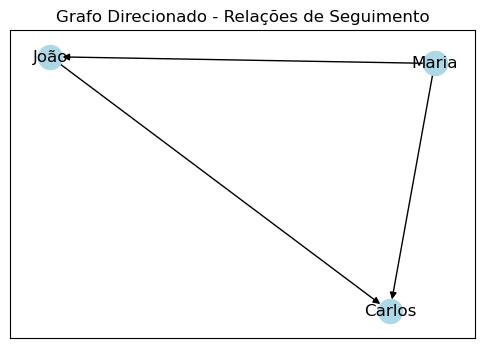

In [7]:
# Cria uma figura com tamanho definido para exibição do grafo
plt.figure(figsize=(6,4))

# Desenha o grafo na tela
nx.draw_networkx(
    G,                     # O grafo a ser desenhado
    with_labels=True,      # Mostra os nomes dos nós
    node_color='lightblue',# Cor dos nós
    arrows=True            # Habilita as setas indicando a direção das conexões
)

# Título do gráfico
plt.title("Grafo Direcionado - Relações de Seguimento")

# Exibe o gráfico
plt.show()

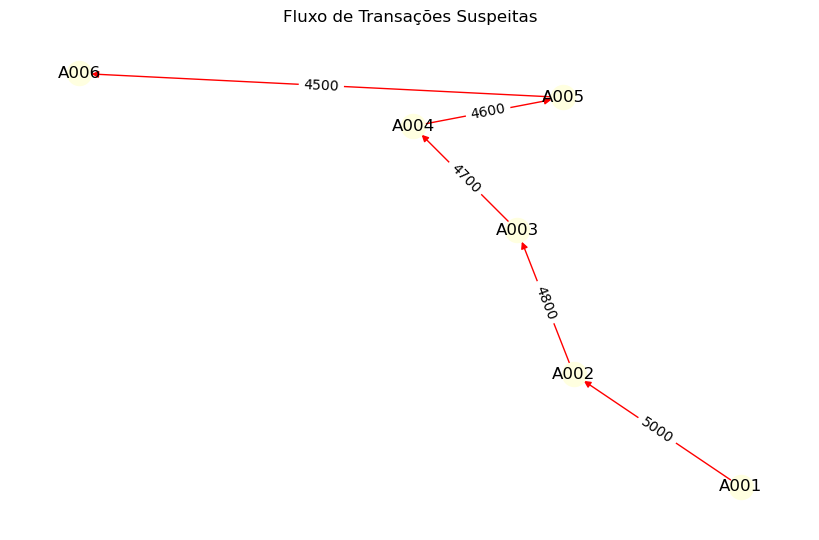

In [ ]:
# Cria o grafo direcionado --> Transações suspeitas
G1 = nx.DiGraph()

# Nós
contas = ["A001", "A002", "A003", "A004", "A005", "A006"]
G1.add_nodes_from(contas)

# Arestas suspeitas
G1.add_edge("A001", "A002", valor=5000)
G1.add_edge("A002", "A003", valor=4800)
G1.add_edge("A003", "A004", valor=4700)
G1.add_edge("A004", "A005", valor=4600)
G1.add_edge("A005", "A006", valor=4500)

# Plot
plt.figure(figsize=(8, 5))
pos = nx.spring_layout(G1, seed=42)
nx.draw(G1, pos, with_labels=True, node_color='lightyellow', edge_color='red', arrows=True)
nx.draw_networkx_edge_labels(G1, pos, edge_labels=nx.get_edge_attributes(G1, 'valor'))
plt.title("Fluxo de Transações Suspeitas")
plt.show()

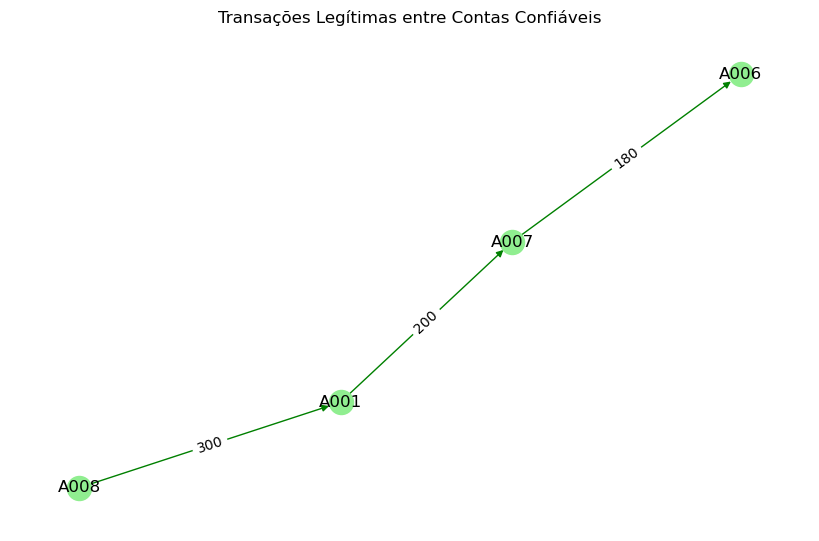

In [16]:
# Cria o grafo --> Trasações confiaveis
G2 = nx.DiGraph()

# Nós envolvidos em transações legítimas
G2.add_nodes_from(["A001", "A006", "A007", "A008"])

# Arestas legítimas
G2.add_edge("A001", "A007", valor=200)     # Transação pequena confiável
G2.add_edge("A007", "A006", valor=180)     # Outra transação pequena
G2.add_edge("A008", "A001", valor=300)     # Reverso, ainda legítimo

# Plot
plt.figure(figsize=(8, 5))
pos = nx.spring_layout(G2, seed=42)
nx.draw(G2, pos, with_labels=True, node_color='lightgreen', edge_color='green', arrows=True)
nx.draw_networkx_edge_labels(G2, pos, edge_labels=nx.get_edge_attributes(G2, 'valor'))
plt.title("Transações Legítimas entre Contas Confiáveis")
plt.show()


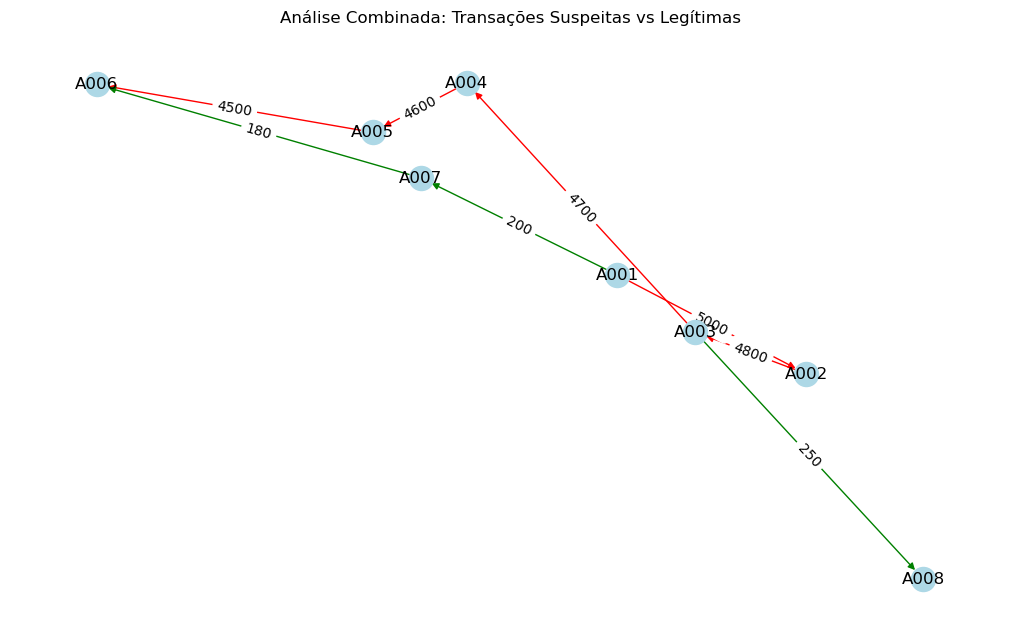

In [13]:
# Cria grafo combinado
G3 = nx.DiGraph()

# Nós
contas = ["A001", "A002", "A003", "A004", "A005", "A006", "A007", "A008"]
G3.add_nodes_from(contas)

# Arestas suspeitas (vermelhas)
G3.add_edge("A001", "A002", valor=5000, tipo='suspeita')
G3.add_edge("A002", "A003", valor=4800, tipo='suspeita')
G3.add_edge("A003", "A004", valor=4700, tipo='suspeita')
G3.add_edge("A004", "A005", valor=4600, tipo='suspeita')
G3.add_edge("A005", "A006", valor=4500, tipo='suspeita')

# Arestas legítimas (verdes)
G3.add_edge("A001", "A007", valor=200, tipo='legitima')
G3.add_edge("A007", "A006", valor=180, tipo='legitima')
G3.add_edge("A003", "A008", valor=250, tipo='legitima')

# Layout e plot
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G3, seed=42)

# Cores condicionais
edge_colors = ['red' if G3[u][v]['tipo'] == 'suspeita' else 'green' for u, v in G3.edges()]

nx.draw(G3, pos, with_labels=True, node_color='lightblue', edge_color=edge_colors, arrows=True)
nx.draw_networkx_edge_labels(G3, pos, edge_labels={(u, v): G3[u][v]['valor'] for u, v in G3.edges()})
plt.title("Análise Combinada: Transações Suspeitas vs Legítimas")
plt.show()
